In [1]:
import sys
sys.path.insert(0, "../../python")

import os
import numpy as np
from vsim import plot
from vsim import load
from vsim import analyze
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('notes')
from scipy.optimize import curve_fit
import scipy.constants as const
from scipy.interpolate import interp1d
me = const.physical_constants['electron mass energy equivalent in MeV'][0]
c = const.physical_constants['speed of light in vacuum'][0]

pathPre = '/media/robert/Data_Storage/VSim/Matched-Accelerating-Gradient/3DConvergence_Tests/'
simName = 'AccelGradient'

def sineline(x, a, x_0, Ed):
    x = np.array(x)
    out = np.empty(len(x))
    # Sin part
    sel = np.logical_and(x > (x_0-np.pi/(2*a)), x < (x_0+np.pi/(2*a)))
    out[sel] = Ed*np.cos(a*(x[sel]-x_0))
    # Line part
    sel = x <= (x_0-np.pi/(2*a))
    out[sel] = Ed*a*x[sel] + (np.pi/(2*a)-x_0)*Ed*a
    # Zeros
    sel = x >= (x_0+np.pi/(2*a))
    out[sel] = 0.0
    return out

[a, x_0, Ed] [  1.64858386e-02   4.29709147e+02   1.43855407e+01]


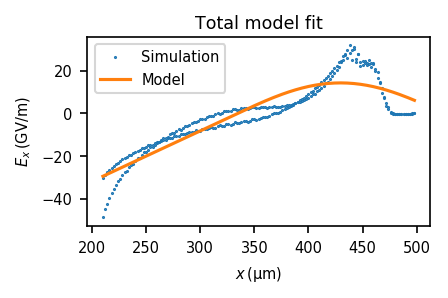

In [2]:
# Fit the model for 1e16 plasma density
path = pathPre + '5e16PlasmaDensity/InitialWakeSize/'
Efield, Eattrs = load.load_field(path, simName, 'edgeE')
Nx, Ny, Nz = analyze.get_shape(Efield[2])
x = np.linspace(0, 500, Nx)
lim = [105, 250]
E4 = Efield[4][:, int((Ny+1)/2), int((Nz+1)/2), 0][lim[0]:lim[1]]/1e9
E5 = Efield[5][:, int((Ny+1)/2), int((Nz+1)/2), 0][lim[0]:lim[1]]/1e9
x = x[lim[0]:lim[1]]

plt.figure(figsize=(3,2), dpi=150)
gs = gridspec.GridSpec(1, 1)
EA = np.concatenate([E4, E5])
xA = np.concatenate([x, x])
poptA, pcov = curve_fit(sineline, xA, EA, p0=[0.01, 350, 10], maxfev=10000)
print('[a, x_0, Ed]', poptA)
plt.subplot(gs[0, 0])
plt.plot(xA, EA, marker='o', linestyle='None', markersize=0.5)
plt.plot(x, sineline(x, *poptA))
plt.title('Total model fit')
plt.xlabel(r'$x\,(\mathrm{\mu m})$')
plt.ylabel(r'$E_x\,(\mathrm{GV/m})$')
plt.legend(['Simulation', 'Model'])
plt.tight_layout()
plt.show()
# This fit is crap, what's propbably easier is to look at the field a certain distance behind the drive beam

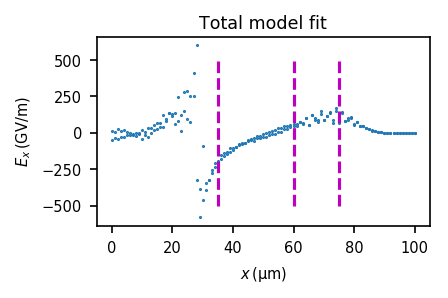

In [3]:
# Fit the model for 1e16 plasma density
path = pathPre + '1e18PlasmaDensity/InitialWakeSize/'
Efield, Eattrs = load.load_field(path, simName, 'edgeE')
Nx, Ny, Nz = analyze.get_shape(Efield[2])
x = np.linspace(0, 100, Nx)
E4 = Efield[4][:, int((Ny+1)/2), int((Nz+1)/2), 0]/1e9
E5 = Efield[5][:, int((Ny+1)/2), int((Nz+1)/2), 0]/1e9

plt.figure(figsize=(3,2), dpi=150)
EA = np.concatenate([E4, E5])
xA = np.concatenate([x, x])
plt.plot(xA, EA, marker='o', linestyle='None', markersize=0.5)
plt.plot([75, 75], [-500, 500], 'm--')
plt.plot([60, 60], [-500, 500], 'm--')
plt.plot([35, 35], [-500, 500], 'm--')
plt.title('Total model fit')
plt.xlabel(r'$x\,(\mathrm{\mu m})$')
plt.ylabel(r'$E_x\,(\mathrm{GV/m})$')
plt.tight_layout()
plt.show()
# This fit is crap, what's propbably easier is to look at the field a certain distance behind the drive beam

In [4]:
# Lets find the acceleration as a function of witness delay
sims = [
    '1e16PlasmaDensity',
    '5e16PlasmaDensity',
    '1e17PlasmaDensity',
    '5e17PlasmaDensity',
    '1e18PlasmaDensity'
]
X = [
    500,
    300,
    300,
    120,
    100
]
N = len(sims)
M = 6
delay = np.linspace(15, 40, M)
ne = np.array([1e16, 5e16, 1e17, 5e17, 1e18], dtype='double')
E = np.zeros((M, N), dtype='double')

for i in range(N):
    path = pathPre + sims[i] + '/InitialWakeSize/'
    Efield, Eattrs = load.load_field(path, simName, 'edgeE')
    Nx, Ny, Nz = analyze.get_shape(Efield[2])
    x = np.linspace(0, X[i], Nx)
    E4 = Efield[4][:, int((Ny+1)/2), int((Nz+1)/2), 0]/1e9
    E5 = Efield[5][:, int((Ny+1)/2), int((Nz+1)/2), 0]/1e9
    field4 = interp1d(x, E4)
    field5 = interp1d(x, E5)
    for j in range(M):
        E[j, i] = (field4(X[i]-25-delay[j]) + field5(X[i]-25-delay[j]))/2

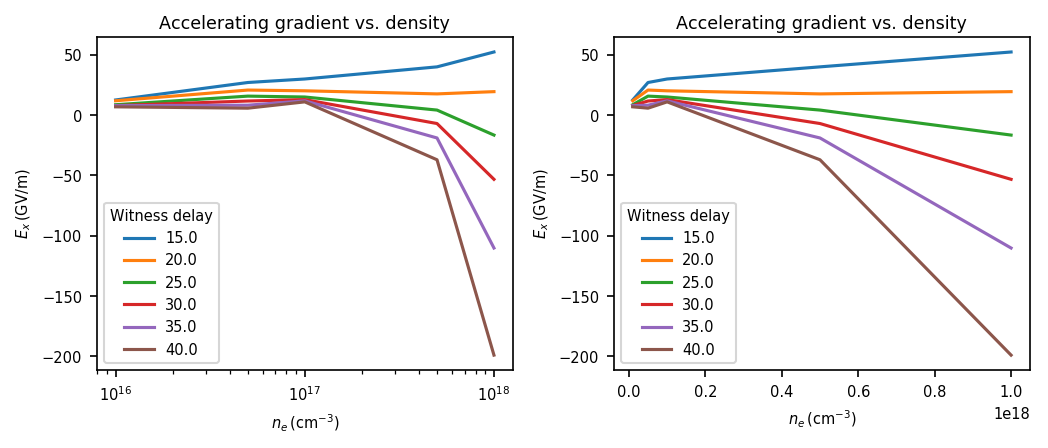

In [11]:
plt.figure(figsize=(7,3), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0,0])
plt.plot(ne, E[0, :], ne, E[1, :], ne, E[2, :], ne, E[3, :], ne, E[4, :], ne, E[5, :])
plt.title('Accelerating gradient vs. density')
plt.xlabel(r'$n_e\,(\mathrm{cm^{-3}})$')
plt.ylabel(r'$E_x\,(\mathrm{GV/m})$')
plt.legend(delay, title='Witness delay')
plt.xscale('log')

plt.subplot(gs[0,1])
plt.plot(ne, E[0, :], ne, E[1, :], ne, E[2, :], ne, E[3, :], ne, E[4, :], ne, E[5, :])
plt.title('Accelerating gradient vs. density')
plt.xlabel(r'$n_e\,(\mathrm{cm^{-3}})$')
plt.ylabel(r'$E_x\,(\mathrm{GV/m})$')
plt.legend(delay, title='Witness delay')
plt.tight_layout()
plt.show()